In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [71]:
#Import Required Libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
import pathlib
import io
import os
import re
import string
import time
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Layer,Flatten,SimpleRNN,Input,InputLayer,Conv1D,Bidirectional,LSTM,GRU,BatchNormalization,Dropout,Embedding,TextVectorization, GlobalAveragePooling1D,GlobalMaxPool1D 
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorboard.plugins import projector


In [72]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [73]:
df.sample(5)

,review,sentiment
47144,I saw this movie Sunday afternoon. I absolutel...,positive
43341,this is one amazing movie!!!!! you have to rea...,positive
9120,"I'm a fan of good, plausible, action movies. A...",negative
31430,For some strange reason the film world is driv...,negative
9981,"That's right, we've got a 2008 film using them...",positive


In [74]:
df.shape #50000,2

(50000, 2)

In [75]:
type(df)

pandas.core.frame.DataFrame

In [76]:
import random
n = random.randint(0,len(df))
for _ in range(1):
    print(df.iloc[:,0][n])

What can you expect from a direct to DVD film? You know what you are getting yourself into when you rent this. The quality of the cinematography reminds me of reality TV shows. <br /><br />Why are they shots always up so close to the actors!? And why are they always centered? There isn't anything to look at. (And the actors are that great looking, so that blows.)<br /><br />The writing and dialogue is just plain awful. That intro scene, with the British Guy is hilarious. Just try and listen this words, they hardly make any sense, just goes around in circles. The lines in the rest of the movie sounds like they were pull out of romance and sci-fi novels, as if the writers had no idea what they were doing. The characters definitely sound like they have no idea what they're saying. <br /><br />This is a terrible movie. I feel bad for the actors tied to this project. Embarrassing!


In [77]:
#Inference: Review has 's, (),/,Uppercase,?,html tags<>,: which needs to be removed 

In [78]:
import string
string.punctuation
def standardization(data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    x = tf.strings.lower(data) #all strings to lower
    x=tf.strings.regex_replace(x,"<[^>]+>","") # removing html
    data=tf.strings.regex_replace(x,"[%s]"%re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'),"")#removing punctuation
    return data
    
    
    

In [79]:
string = " Married To The Mob was one of the first VHS tapes that I had along with Coming To America and Grease. I still have fond memories of this film after all these years. Hell, I still have the VHS of this film in good condition.<br /><br />The story: Undercover cop Mike Downey(Matthew Modine)is sent to spy on Angela De Marco(Michelle Pfeiffer) the wife of the slain mafia member Frank De Marco(Alec Baldwin). He later falls in love with her after he realizes that she is innocent in all this. Angela not only has to deal with the unwanted advances of mob boss Tony 'The Tiger' Russo(Dean Stockwell), she also has to deal with his jealous wife Connie Russo(Mercedes Ruehl).<br /><br />Married To The Mob is funny and still keeps your interest when its not trying to be funny. I like the little jabs it takes at mafia life(the jealous mafia wife, the mob boss that doesn't realize that he is not a chick magnet etc) and you like the characters of Angela De Marco and Mike Downey. It was the last of the funny phase of Johnathan Demme before he got serious and gave you gems like Philadelphia and Silence Of The Lambs(best thriller of all time). If you're in the mood for comedy, Married To The Mob is a keeper. Its better than the rubbish that passes for comedy nowadays (Epic Movie,<br> Date Movie...</br>, Meet The Spartans, Disaster Movie etc)."
standardization(string)

<tf.Tensor: shape=(), dtype=string, numpy=b' married to the mob was one of the first vhs tapes that i had along with coming to america and grease i still have fond memories of this film after all these years hell i still have the vhs of this film in good conditionthe story undercover cop mike downeymatthew modineis sent to spy on angela de marcomichelle pfeiffer the wife of the slain mafia member frank de marcoalec baldwin he later falls in love with her after he realizes that she is innocent in all this angela not only has to deal with the unwanted advances of mob boss tony the tiger russodean stockwell she also has to deal with his jealous wife connie russomercedes ruehlmarried to the mob is funny and still keeps your interest when its not trying to be funny i like the little jabs it takes at mafia lifethe jealous mafia wife the mob boss that doesnt realize that he is not a chick magnet etc and you like the characters of angela de marco and mike downey it was the last of the funny ph

In [80]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(df)-5) # create random indexes not higher than the total number of samples
for row in df[["review", "sentiment"]][random_index:random_index+5].itertuples():
    _,review,sentiment = row
    print(f"Sentiment is {sentiment}")
    print(review)
    print('----------\n')
    
    

Sentiment is negative
This is one of those films you can have on for a couple of hours on a Sunday morning -- able to do other things with no real complications in losing any understanding of the proceedings, and gaining some fascination in wondering why such mediocrities acquired the manpower and financial resources to be produced in the first place.<br /><br />Of course, with all the cable channels, as well as Lifetime's need to fill its time slots with 100 or so hours worth of movies per week (along with incessant "Golden Girls" reruns), this type of fare is now a t.v. staple. Also, it seems these flicks provide livelihood to the Canadian locales where most are made, as well as the host of Canadian actors appearing in them.<br /><br />Tori Spelling, like the ferret-face Paris Hilton, is somebody who - if not for family connections and resources - would likely be working at The Gap. But at least Tori has become, say, a C+-level thespian, appearing in occasional presentations appropri

In [81]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [82]:
df['sentiment'] = np.where(df['sentiment']=='positive',1,0)

In [83]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [84]:
X = df['review']
y = df['sentiment']

In [85]:
#We will split our data into train, test
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


X_test, X_val, y_test, y_val = train_test_split(X_val,
                                                    y_val,
                                                    test_size=0.5,
                                                    random_state=42)


In [86]:
len(X_train), len(X_val), len(X_test)

(40000, 5000, 5000)

In [87]:
X_train.shape, y_train.shape

((40000,), (40000,))

In [88]:
#Finding average no of words in a sentence or max_tokens
print(sum([len(i.split()) for i in df['review']])/len(df['review']))

231.15694


In [89]:
max_token = 20000
output_sequence_length = 200

In [90]:
#Let's Standardize the text, we will remove html tags, punctuation and then proceed
textvectorizer = TextVectorization(
    max_tokens=max_token,
    standardize=standardization,
    split='whitespace',
    output_sequence_length= output_sequence_length
)

In [91]:
# Fit the text vectorizer to the training text
textvectorizer.adapt(X_train)

Training data mapped! Let's try our text_vectorizer on a custom sentence (one similar to what you might see in the training data).

In [92]:
sample = 'This movie was good and vfx were desent. Acting was ,. <br>ok</br>'
standardization(sample)

<tf.Tensor: shape=(), dtype=string, numpy=b'this movie was good and vfx were desent acting was  ok'>

In [93]:
textvectorizer(sample)

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([ 11,  17,  13,  49,   3,   1,  66,   1, 111,  13, 600,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  

In [94]:
#trying text_vectorization on random sentence
sentence = random.choice(X_train)
textvectorizer(sentence)

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([  105,    31,   690, 14345,    11,    28,     7,    32,   223,
           2,   115,     5,    31,    10,   148,    25,    72,  6424,
          52,    10,   182,     2,     1,    13,   134,     4,  2097,
          18,     6,    55,  3054,    11,    28,    13,   837,  2595,
          15,    46,  4339,     1,   689,    11,    28,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [95]:
words = textvectorizer.get_vocabulary()
print(f"Top 10 words {words[:10]}")
print(f"Top 10 least frequent words {words[-10:]}")
len(words)

Top 10 words ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']
Top 10 least frequent words ['braga', 'brag', 'bradshaw', 'bradburys', 'boundless', 'bottomless', 'borgnine', 'booty', 'bohringer', 'bogie']


20000

In [96]:
#Till now we just got some numbers as int, we need to turn them into Embedding

embedding_1 = Embedding(input_dim=max_token,#20000
                         output_dim = 512,
                         input_length=output_sequence_length,#200
                         name='embedding_1'
                       )

embedding_1

In [97]:
#Passing a sample sentence
embedding_random_sentence = random.choice(X_train)
print(embedding_random_sentence)
embedding_1(textvectorizer([embedding_random_sentence]))

Such a delightful movie! Very heart warming. One can't help falling in love with the character of Gigi. He's adorable as a child and grows into a sensitive artist. The whole movie revolves around him. He lives in a wonderful world  living all life  curiosity, desire and anticipation. There is an elder brother who tries to steal his glory but really remains in the shadow all his life. The father is very stereotypically Italian and so is the mother. I wanted the father to come and reunite with the mother in the last scene  and have them cry and laugh. I also wish that there was at least something redeeming about the elder brother. His personality seems to have been trashed entirely. Passion and ardour  that's the key to life. And looking through the camera  focusing on small details and savoring the delicate details of life.


<tf.Tensor: shape=(1, 200, 512), dtype=float32, numpy=
array([[[ 0.00130594,  0.02888646, -0.01855167, ..., -0.02943879,
          0.0447549 , -0.02232668],
        [ 0.01230633, -0.00467271, -0.04223078, ...,  0.03760214,
          0.02573713,  0.04525654],
        [ 0.00938807, -0.00074945,  0.04061452, ...,  0.04527311,
          0.02953715,  0.04523269],
        ...,
        [-0.02726548,  0.03379958,  0.03541889, ..., -0.01737641,
         -0.03248243,  0.02356156],
        [-0.02726548,  0.03379958,  0.03541889, ..., -0.01737641,
         -0.03248243,  0.02356156],
        [-0.02726548,  0.03379958,  0.03541889, ..., -0.01737641,
         -0.03248243,  0.02356156]]], dtype=float32)>

In [98]:
#Basic Flow till now

#Standardization ==> TextVectorizer ==> Embedding

In [99]:
import datetime

SAVE_DIR = "model_logs"
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [100]:
#Model_checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)

In [101]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

In [102]:
# Function to evaluate: accuracy, precision, recall, f1-score, ready made fn is avaliable for all 3 except accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted") # check about weighted
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [103]:
#Visualizing our Models

def visualModellossAccuracy(model_history):
    """
    For Loss
    """
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.legend(['Training','Validation'],loc='upper left')
    plt.show()
    
    """
    For Accuracy
    """
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training','Validation'],loc='upper left')
    
    plt.show()
    
    
    
    

In [104]:

# Model 1: Feed-forward Dense neural network using SimpleRNN
# Model 2: Feed-forward Dense neural network using GlobalAveragePooling1D
# Model 3: 1D Convolutional Neural Network using GlobalMaxPooling1D
# Model 4: Bidirectional-LSTM model
# Model 5: Bidirectional-GRU model + Dropout
# Model 6: TensorFlow Hub Pretrained Feature Extractor using Sequential API

In [105]:
#We will begin with Model buliding


In [106]:
#Model 1:Feed-forward neural network dense model
max_token = 20000
output_sequence_length = 250
embedding_dims = 512

#Creating Functional Model
inputs = Input(shape=(1,),dtype='string')
x = textvectorizer(inputs)
x = embedding_1(x)
x = SimpleRNN(32,activation='relu')(x)
outputs = Dense(1, activation="sigmoid")(x) 
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

print(model_1.summary())
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_1_history = model_1.fit(X_train, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              #callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="simpleRNN_dense_model")]
                             )

# Check the results
model_1.evaluate(X_val, y_val)

# embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
# print(embed_weights.shape)

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 200, 512)          10240000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                17440     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,257,473
Trainable params: 10,257,473
Non-trainable params: 0
_________________________________________

[0.7315518856048584, 0.5303999781608582]

In [107]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [108]:
model_1_preds = model_1.predict(X_test)
model_1_preds[:5], model_1_preds.shape

157/157 [==============================] - 3s 18ms/step


(array([[0.00538745],
        [0.20469514],
        [0.51565963],
        [0.51565963],
        [0.51565963]], dtype=float32),
 (5000, 1))

In [109]:
model_1_preds = tf.squeeze(tf.round(model_1_preds))

In [110]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=y_val,
                                    y_pred=model_1_preds)
model_1_results
visualModellossAccuracy(model_2_history)

NameError: name 'model_2_history' is not defined

In [ ]:
visualModellossAccuracy(model_1_history)

In [ ]:
#Model2 - Feed Forward NN with GlobalAveragePooling1d

max_token = 20000
output_sequence_length = 250
embedding_dims = 512

#Creating Functional Model
inputs = Input(shape=(1,),dtype='string')
x = textvectorizer(inputs)
x = embedding_1(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1,activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs,outputs,name='model_2_globalAvgPool1D')

In [ ]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=["accuracy"])

# Fit the model
model_2_history = model_2.fit(X_train, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              #callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="GlobalAvgPooling1D_dense_model")]
                             )

In [ ]:
# Check the results
model_2.evaluate(X_val, y_val)

In [ ]:
# Check the results

model_2_preds = model_2.predict(X_test)
model_2_preds = tf.squeeze(tf.round(model_2_preds))

# Calculate model_2 metrics
model_2_results = calculate_results(y_true=y_val,
                                    y_pred=model_2_preds)
print(model_2_results)


In [ ]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(new_model_results,baseline_results=model_1_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(new_model_results=model_2_results)

In [ ]:
visualModellossAccuracy(model_2_history)

In [ ]:
#Model 3: 1D Convolutional Neural Network using GlobalAveragePooling1D

tf.random.set_seed(42)


max_token = 20000
output_sequence_length = 250
embedding_dims = 512


inputs = Input(shape=(1,), dtype="string")
x = textvectorizer(inputs)
x = embedding_1(x)
x = Conv1D(filters=32, kernel_size=5, activation="relu")(x) # stride and padding can also be added ie 1,valid
x = GlobalMaxPool1D()(x)
outputs = Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_GlobalMaxPool1D")



# Compile Conv1D model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
print(model_3.summary())

# Fit the model
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              #callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D_GlobalMaxPool1D")]
                             )

In [ ]:
# Check the results
model_3.evaluate(X_val, y_val)

In [ ]:

model_3_preds = model_3.predict(X_test)
model_3_preds = tf.squeeze(tf.round(model_3_preds))

# Calculate model_2 metrics
model_3_results = calculate_results(y_true=y_val,
                                    y_pred=model_3_preds)
print(model_3_results)

# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(new_model_results,baseline_results=model_1_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(new_model_results=model_3_results)

In [ ]:
visualModellossAccuracy(model_3_history)

In [ ]:
#Model 4: Bidirectional-LSTM model

tf.random.set_seed(42)


max_token = 20000
output_sequence_length = 250
embedding_dims = 512


inputs = Input(shape=(1,), dtype="string")
x = textvectorizer(inputs)
x = embedding_1(x)
x = Bidirectional(LSTM(64,return_sequences=True))(x)
x = LSTM(64)(x)
outputs = Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_BRNN_LSTM")



# Compile Conv1D model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our Birectional LSTM
print(model_4.summary())

# Fit the model
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              #callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     #"BRNN_LSTM")]
                             )

In [ ]:
# Check the results
model_4.evaluate(X_val, y_val)

In [ ]:

model_4_preds = model_4.predict(X_test)
model_4_preds = tf.squeeze(tf.round(model_4_preds))

# Calculate model_2 metrics
model_4_results = calculate_results(y_true=y_val,
                                    y_pred=model_4_preds)
print(model_4_results)

# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(new_model_results,baseline_results=model_4_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(new_model_results=model_4_results)

In [ ]:
visualModellossAccuracy(model_4_history)

In [ ]:
#Model 5: Bidirectional-GRU model

tf.random.set_seed(42)


max_token = 20000
output_sequence_length = 250
embedding_dims = 512


inputs = Input(shape=(1,), dtype="string")
x = textvectorizer(inputs)
x = embedding_1(x)
x = Bidirectional(GRU(64,return_sequences=True))(x)
x = Dropout(0.5)(x)
x = GRU(64)(x)
outputs = Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_BRNN_LSTM")



# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our Birectional LSTM
print(model_5.summary())

# Fit the model
model_5_history = model_5.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              #callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    # "BRNN_GRU")]
                             )

In [ ]:
# Check the results
model_5.evaluate(X_val, y_val)

In [ ]:

model_5_preds = model_5.predict(X_test)
model_5_preds = tf.squeeze(tf.round(model_5_preds))

# Calculate model_2 metrics
model_5_results = calculate_results(y_true=y_val,
                                    y_pred=model_5_preds)
print(model_5_results)

# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(new_model_results,baseline_results=model_5_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(new_model_results=model_5_results)

In [ ]:
visualModellossAccuracy(model_5_history)

In [112]:
#Model 6: Using Pre-Trained load Universal Sentence Encoder
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed(["When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])
embed_samples[0].shape

tf.Tensor(
[ 0.03596691 -0.08579469 -0.01152743  0.00525982 -0.01852172 -0.05042012
 -0.03616941  0.00534677  0.04805917  0.04690744 -0.0372333  -0.01149546
  0.04352415  0.07050991  0.0709376  -0.08180431  0.00871717 -0.04654121
 -0.02245776  0.04686872  0.00202256  0.03099072  0.02043563  0.06392168
 -0.07641086  0.08421179 -0.04576042 -0.00106165 -0.02059416  0.01241106
  0.05727539  0.0381562  -0.02742118 -0.00354347 -0.09832586 -0.01244854
  0.0386563   0.05031953 -0.02362506  0.00321848  0.03225209  0.00738095
  0.04473104 -0.00412236  0.01151601  0.02837724  0.00060139 -0.05903354
 -0.00494347 -0.00688527], shape=(50,), dtype=float32)


TensorShape([512])

In [113]:
# Each sentence has been encoded into a 512 dimension vector
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], 
# shape of inputs coming to our model, input can be of variable length, 
#we hard coded this or fixed it in our previous model but output is going to be 512 vector
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [133]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  Dense(64, activation="relu"),
  Dropout(0.5),
  Dense(64, activation="relu"),
  Dropout(0.5),
  Dense(32, activation="relu"),
  Dense(8, activation="relu"),
  Dense(1, activation="sigmoid") # output layer
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_34 (Dense)            (None, 64)                32832     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 8)                 

In [134]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(X_train,
                              y_train,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[model_checkpoint,early_stopping]
                             )
                              

Epoch 1/20
1249/1250 [============================>.] - ETA: 0s - loss: 0.3941 - accuracy: 0.8219
Epoch 1: val_accuracy did not improve from 0.87200
1250/1250 [==============================] - 68s 52ms/step - loss: 0.3941 - accuracy: 0.8218 - val_loss: 0.3199 - val_accuracy: 0.8616
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 0.3399 - accuracy: 0.8563
Epoch 2: val_accuracy did not improve from 0.87200
1250/1250 [==============================] - 63s 50ms/step - loss: 0.3399 - accuracy: 0.8563 - val_loss: 0.3150 - val_accuracy: 0.8640
Epoch 3/20
1250/1250 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8609
Epoch 3: val_accuracy did not improve from 0.87200
1250/1250 [==============================] - 58s 46ms/step - loss: 0.3291 - accuracy: 0.8609 - val_loss: 0.3123 - val_accuracy: 0.8656
Epoch 4/20
1249/1250 [============================>.] - ETA: 0s - loss: 0.3254 - accuracy: 0.8621
Epoch 4: val_accuracy did not improve from 0.87200

In [135]:
# Check the results
model_6.evaluate(X_test, y_test)

157/157 [==============================] - 6s 41ms/step - loss: 0.3104 - accuracy: 0.8690


[0.3103930950164795, 0.8690000176429749]

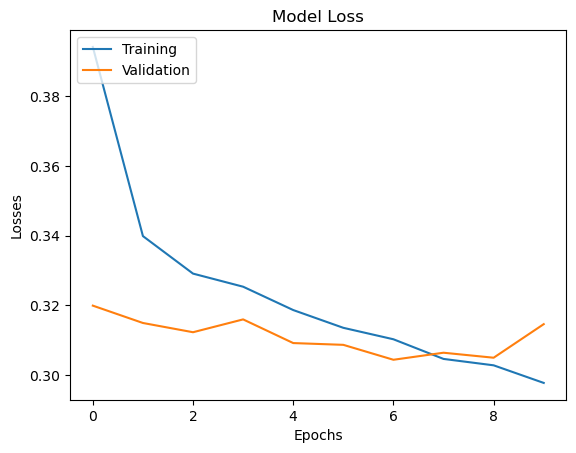

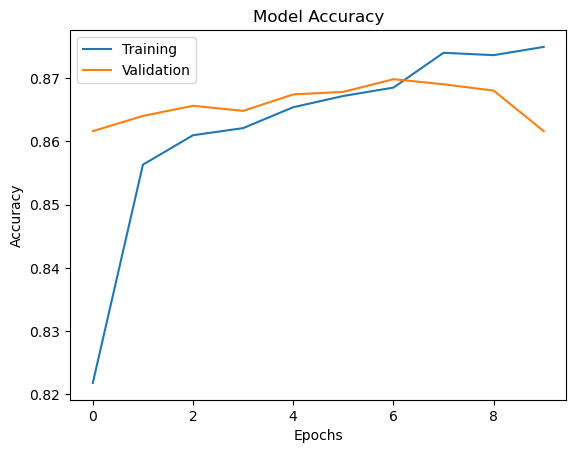

In [136]:
visualModellossAccuracy(model_6_history)

In [137]:
# Make predictions with the model trained on 10% of the data
model_6_pred_probs = model_6.predict(X_test)
model_6_pred_probs[:10]

157/157 [==============================] - 7s 41ms/step


array([[0.04849934],
       [0.01857915],
       [0.9431805 ],
       [0.2544777 ],
       [0.00994976],
       [0.21425804],
       [0.00396176],
       [0.06008441],
       [0.77447313],
       [0.00166507]], dtype=float32)

In [138]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)>

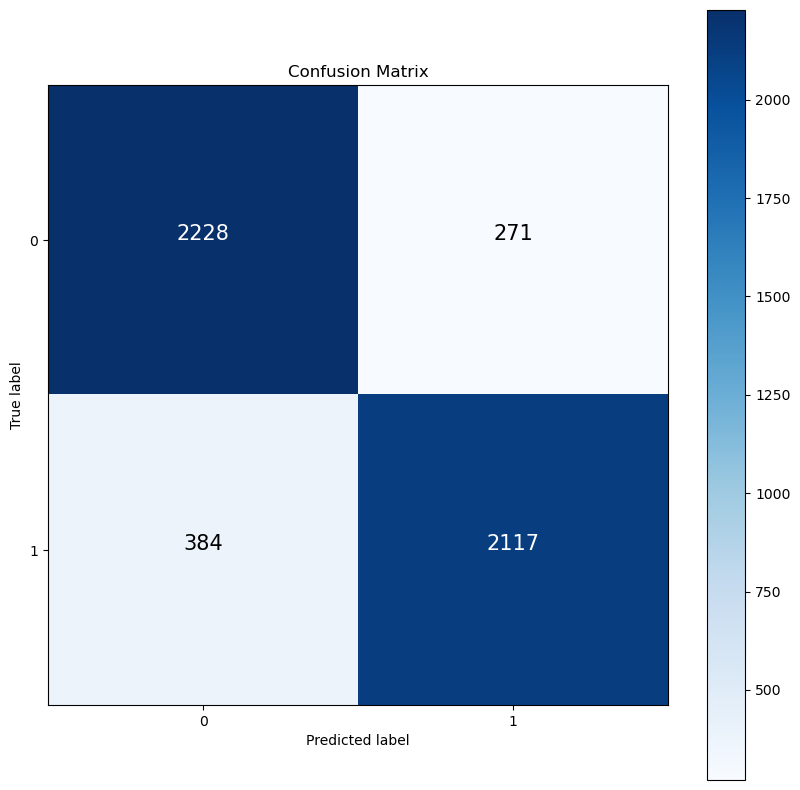

In [141]:
from sklearn.metrics import confusion_matrix
import itertools 
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

#   # Save the figure to the current working directory
#   if savefig:
#     fig.savefig("confusion_matrix.png")

make_confusion_matrix(y_test,model_6_preds)

In [142]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [143]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer}) 
# for save model format used below, no need of custom object

In [144]:
# How does our loaded model perform?
loaded_model_6.evaluate(X_val, y_val)

157/157 [==============================] - 7s 42ms/step - loss: 0.3146 - accuracy: 0.8616


[0.31464460492134094, 0.8615999817848206]

In [145]:
# Create dataframe with validation sentences and best performing model predictions
#--Github resource link is not present below. Watch video 248 later to download the zip file for below from github
val_df = pd.DataFrame({"text": X_test,
                       "target": y_test,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
47374,Hollywood has churned out yet another garbage ...,0,0.0,0.048499
48216,A trooper is on the side of the road making su...,0,0.0,0.018579
45929,If you like his show you might be a little dis...,1,1.0,0.943181
48715,A squashy slapstick mess posing as a comedy. E...,0,0.0,0.254478
18849,Lucio Fulci was famous for his Italian splatte...,0,0.0,0.009950


In [146]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
35968,As many have detailed here with a level of ser...,0,1.0,0.997064
39301,"Algiers is not a classic, it is a perversion o...",0,1.0,0.993906
17203,I couldn't give this film a bad rating or bad ...,0,1.0,0.984595
20634,normally i'm not the sort to be scared by horr...,0,1.0,0.977655
13539,We don't know if Darlene loves all three gentl...,0,1.0,0.977463
30799,(This is a review of the later English release...,0,1.0,0.977028
48415,"Based on the comments made so far, everyone se...",0,1.0,0.975561
49307,I watched this film on the Hallmark Channel re...,0,1.0,0.969335
33656,Blood Surf AKA Krocodylus is a fair film that ...,0,1.0,0.969018
42048,I watched this episode with high hopes after s...,0,1.0,0.963327


In [147]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row # empty because of index
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9970641136169434
Text:
As many have detailed here with a level of seriousness that I find amusing, this is *not*: <br /><br />A FILM. (cue dramatic music) <br /><br />It's just a so-bad-it's good, totally surreal, Jackie Chan stunt-for-all. The women fighters are totally kick-butt and Jackie is definitely put in his place. <br /><br />This is the movie you want to see with some good friends on a Sunday afternoon -- surrounded by munchies, ready to roar with laughter, cheer on the good guys, boo the bad guys, and continually yell, "WHAT?" when something totally bizarre happens. Great fun!!

----

Target: 0, Pred: 1, Prob: 0.9939056634902954
Text:
Algiers is not a classic, it is a perversion of the wonderful original Pepe le Moko, directed by Duvivier and starring a much more attractive and charming Pepe, Jean Gabin. If you want to fully experience the Casbah and the characters in Algiers, I recommend you don't even watch this movie and see Pepe le Moko instea

In [148]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.026731394231319427
Text:
I liked the quiet noir of the first part, the acting of Pacino and Cusak, especially their scenes together. The moodiness of the setting and the juxtaposition of the old pol and the idealistic youth was effecting. I wish Bridget Fonda had more scenes in the movie; she was an earnest and appealing character. The film went off the rails for me when the assistant mayor starting snooping around the mafioso to get to the bottom of something his boss clearly didn't want him meddling in. Nobody in their right mind would meet a mafioso on an abandoned dock in a junkyard. Here the story became implausible. Something that I don't understand: why did the cop and Vito have a shootout if the latter was delivering info that could bring down the corrupt judge?

----

Target: 1, Pred: 0, Prob: 0.026130598038434982
Text:
I'm a bit conflicted over this. The show is on one hand awful, the acting is terrible (even when we get actual name actors like Bra

In [117]:

model_6_preds = model_6.predict(X_test)
model_6_preds = tf.squeeze(tf.round(model_6_preds))

# Calculate model_2 metrics
model_6_results = calculate_results(y_true=y_val,
                                    y_pred=model_6_preds)
print(model_6_results)

# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(new_model_results,baseline_results=model_6_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(new_model_results=model_6_results)

157/157 [==============================] - 7s 42ms/step
{'accuracy': 50.44, 'precision': 0.5044605496988964, 'recall': 0.5044, 'f1': 0.5044222056654788}
Baseline accuracy: 50.44, New accuracy: 50.44, Difference: 0.00
Baseline precision: 0.50, New precision: 0.50, Difference: 0.00
Baseline recall: 0.50, New recall: 0.50, Difference: 0.00
Baseline f1: 0.50, New f1: 0.50, Difference: 0.00


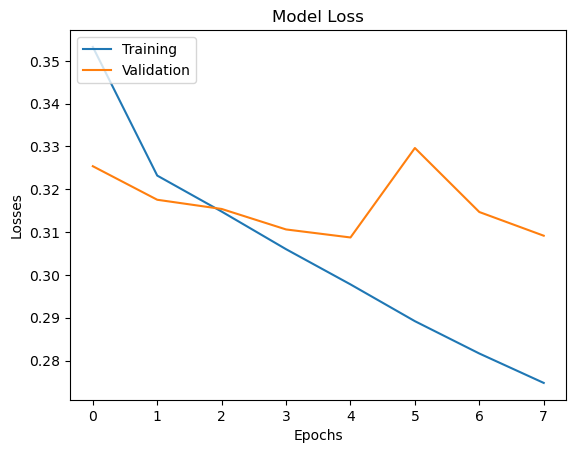

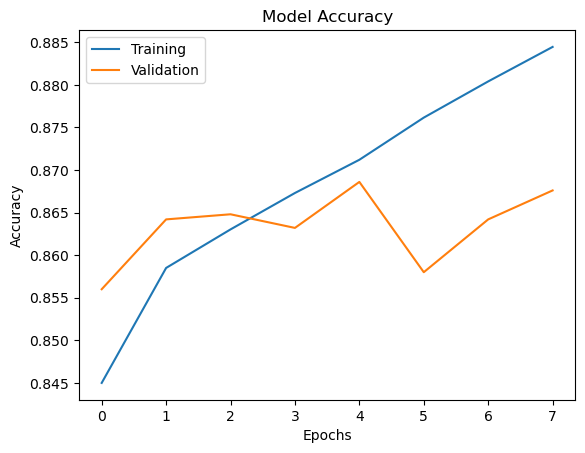

In [151]:
# Turn Review into string
review_negative = "Life like an ensemble: take the best choices from others and make your own. This movie is absolutely crap and doesn't deserve to be released. Non-sense!"
review_positive = 'Movie starts with a action sequence which is stunning. Highly Recommend watching this movie!'

In [149]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(Positive Sentiment)" if pred_label > 0 else "(Negative Sentiment)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [152]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=review_negative)

1/1 [==============================] - 1s 531ms/step
Pred: 0.0 (Negative Sentiment) Prob: 0.333194762468338
Text:
Life like an ensemble: take the best choices from others and make your own. This movie is absolutely crap and doesn't deserve to be released. Non-sense!


In [153]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=review_positive)

1/1 [==============================] - 0s 46ms/step
Pred: 1.0 (Positive Sentiment) Prob: 0.9954029321670532
Text:
Movie starts with a action sequence which is stunning. Highly Recommend watching this movie!


In [ ]:
#Comparing the performance of each of our models
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({
                                  "simple_RNN": model_1_results,
                                  "GlobalAveragePooling1D": model_2_results,
                                  "1D Conv with GlobalMaxPool1D": model_3_results,
                                  "BRNN_LSTM": model_4_results,
                                  "BRNN_GRU_Dropout": model_5_results,
                                  "USE": model_6_results,
                                  })
all_model_results = all_model_results.transpose()
all_model_results


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));